In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
import gseapy as gp
import anndata
from scipy import stats
from eval_utils import *
from plot_utils import *

from matplotlib.colors import LinearSegmentedColormap
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import bar, percentile_bars, percentile_stars, progress_donut
import matplotlib

sns.set_style('whitegrid')

In [349]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
datasets = ['ReplogleK562', 'Norman2019', 'Adamson2016'] # 
dataset_names = ['Replogle_K562_2022', 'Norman2019', 'Adamson2016']
seeds = [1, 2, 3]
methods = ['cpa', 'gears', 'min-pert', 'nonctl-mean', 'matching-mean']
# methods = ['cpa', 'gears', 'scgpt', 'nonctl-mean', 'matching-mean']

In [350]:
results_df = pd.DataFrame(
    columns=["dataset", "method", "pert", "seed", "corr_all", "corr_20de", "mse_all", "mse_20de", "jaccard", "p_corr_all", "p_corr_20de", "p_mse_all", "p_mse_20de", "p_jaccard", "one gene", "train"]
)
for dataset, dataset_name in zip(datasets, dataset_names):
    for seed in seeds:
        file = f'../data/{dataset_name.lower()}/{dataset_name.lower()}_{seed}.h5ad'
        adata = anndata.read_h5ad(file)
    
        # Get control mean, non control mean (pert_mean), and non control mean differential
        train_adata = adata[adata.obs['split'] == 'train']
        control_adata = train_adata[train_adata.obs['control'] == 1]
        pert_adata = train_adata[train_adata.obs['control'] == 0]
        control_mean = np.array(control_adata.X.mean(axis=0))[0]
        pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
        for method in tqdm(methods):
            post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-gt.csv', index_col=[0, 1])
            post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
            conditions = post_gt_df.index.get_level_values('condition').unique()
            for condition in conditions:
                gene_list = condition.split("+")
                one_gene = False
                if "ctrl" in gene_list:
                    gene_list.remove("ctrl")
                    one_gene = True
                one_gene_str = "1-gene" if one_gene else "2-gene"
    
                # Get data
                X_true = post_gt_df.loc[condition].values[0]
                X_pred = post_pred_df.loc[condition].values[0]
                delta_true = X_true - control_mean
                delta_pred = X_pred - control_mean
                p_delta_true = X_true - pert_mean
                p_delta_pred = X_pred - pert_mean
                n_train = post_gt_df.loc[condition].index.get_level_values('n_train').values[0]
    
                # Get top 20 DE genes
                adata_condition = adata[adata.obs["condition"] == condition]
    
                # Select top 20 DE genes
                top20_de_genes = adata.uns["top_non_dropout_de_20"][
                    adata_condition.obs["condition_name"].values[0]
                ]
                top20_de_idxs = np.argwhere(
                    np.isin(adata.var.index, top20_de_genes)
                ).ravel()
                
                # Jaccard similarity
                # top20_de_idxs = get_topk_de_gene_ids(control_mean, X_true, k=20)
                top20_de_idxs_pred = get_topk_de_gene_ids(control_mean, X_pred, k=20)
                p_top20_de_idxs = get_topk_de_gene_ids(pert_mean, X_true, k=20)
                p_top20_de_idxs_pred = get_topk_de_gene_ids(pert_mean, X_pred, k=20)
                
                # Store results
                results_df.loc[len(results_df)] = [
                        # Details
                        dataset,
                        method,
                        condition,
                        seed,

                        # Scores on deltas using control mean
                        pearsonr(delta_true, delta_pred)[0],
                        pearsonr(delta_true[top20_de_idxs], delta_pred[top20_de_idxs])[0],
                        np.mean((delta_true - delta_pred)**2),
                        np.mean((delta_true[top20_de_idxs] - delta_pred[top20_de_idxs])**2),
                        jaccard_similarity(top20_de_idxs, top20_de_idxs_pred),

                        # Scores on deltas using all-perturbation mean
                        pearsonr(p_delta_true, p_delta_pred)[0],
                        pearsonr(p_delta_true[top20_de_idxs], p_delta_pred[top20_de_idxs])[0],
                        np.mean((p_delta_true - p_delta_pred)**2),
                        np.mean((p_delta_true[top20_de_idxs] - p_delta_pred[top20_de_idxs])**2),
                        jaccard_similarity(p_top20_de_idxs, p_top20_de_idxs_pred),

                        # Number of perturbed genes and number of seen perturbations at train time
                        one_gene_str,
                        n_train,
                    ]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79it/s]


In [351]:
results_df['rmse_all'] = np.sqrt(results_df['mse_all'])
results_df['rmse_20de'] = np.sqrt(results_df['mse_20de'])

In [413]:
fontsize = 19
method_names = {
    'cpa': 'CPA',
    'gears': 'GEARS',
     # 'scgpt': 'scGPT',
     # 'min-pert': 'Max depletion',
    'nonctl-mean': 'Non control mean',
    'matching-mean': 'Matching mean'
}

metric_names = {
    'corr_all': 'Pearson↑',
    'corr_20de': 'Pearson$_{20}$↑',
    'rmse_all': 'RMSE↓',
    'rmse_20de': 'RMSE$_{20}$↓',
    'jaccard': 'Jaccard$_{20}$↑'
}

# datasets_ = ['ReplogleK562', 'Adamson2016', 'Norman2019']
dataset_names = {
    'ReplogleK562': 'ReplogleK562',
    'Adamson2016': 'Adamson',
    'Norman2019': 'Norman'
}

results_df['method'] = results_df['method'].replace(method_names)
results_df['dataset'] = results_df['dataset'].replace(dataset_names)

df = results_df[['dataset', 'method'] + list(metric_names.keys())].groupby(['dataset', 'method']).mean()
df = df.round(2)
df_ = df.unstack(level=0).swaplevel(1, 0, axis=1).loc[method_names.values()]

col_defs = [
        ColumnDefinition(
            name="method",
            title="Method",
            textprops={"ha": "center", "fontsize": fontsize},  # "weight": "bold"
            width=1.75,
        ),
    ]

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

cols_order = []
for d in dataset_names.values():
    for m, m_name in metric_names.items():
        cmap_name = matplotlib.cm.PiYG
        if '↓' in m_name:
            cmap_name = matplotlib.cm.PiYG_r
            print(m_name)
            
        col = (d, m)
        cols_order.append(col)
        col_def = ColumnDefinition(
            name=col,
            title=m_name,
            # formatter=decimal_to_percent,
            group=d,
            border="left",
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            formatter="{:.2f}",
            width=1,
            # cmap=cmap
            cmap=normed_cmap(df_[col], cmap=cmap_name, num_stds=2),
        )
        col_defs.append(col_def)

RMSE↓
RMSE$_{20}$↓
RMSE↓
RMSE$_{20}$↓
RMSE↓
RMSE$_{20}$↓


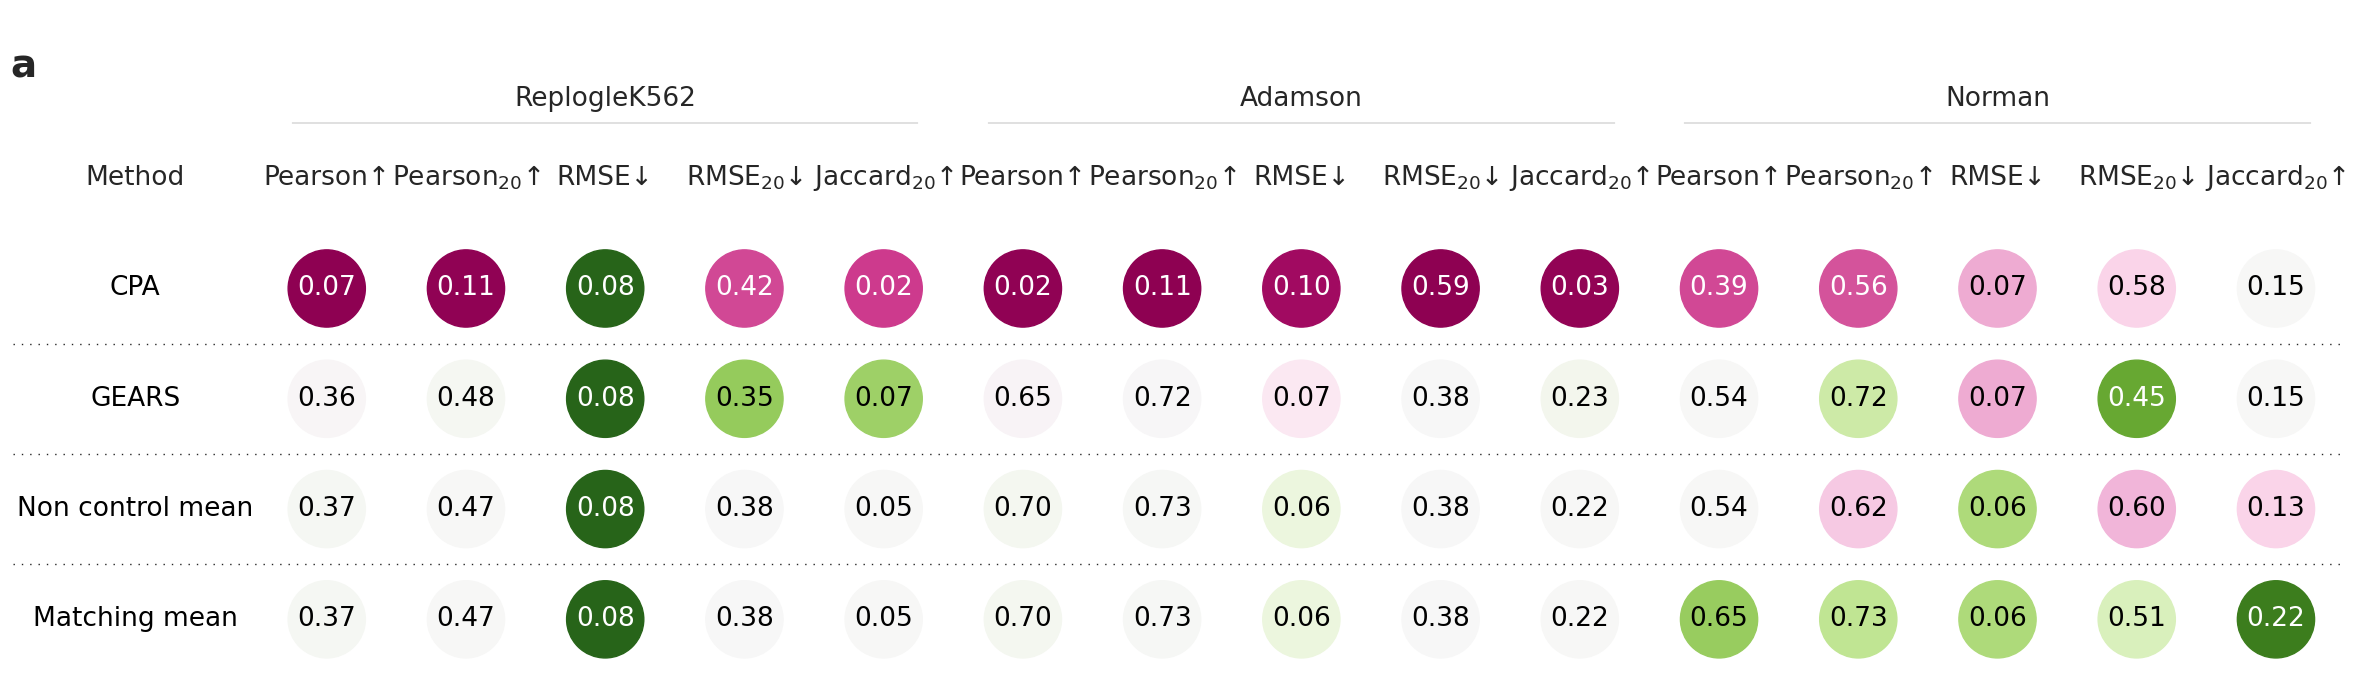

In [423]:
fig, ax = plt.subplots(figsize=(24, 7))

letter_annotation(plt.gca(), 0, 0.9, 'a', fontsize=28)
table = Table(
    df_[cols_order],
    column_definitions=col_defs,
    row_dividers=True,
    col_label_divider=False,
    footer_divider=False,
    # even_row_color='whitesmoke',
    ax=ax,
    textprops={"fontsize": fontsize},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 0, "linestyle": "-"},
).autoset_fontcolors()  # colnames=["OFF", "DEF"]
plt.tight_layout()
plt.savefig(f'{figdir}/benchmark_summary_table.pdf', bbox_inches='tight');

#### Biggest expression change baseline

In [332]:
dataset_name = 'Replogle_k562_2022'
file = f'../data/{dataset_name.lower()}/{dataset_name.lower()}_{seed}.h5ad'
adata = anndata.read_h5ad(file)

In [342]:
test_adata = adata[adata.obs['split'] == 'test']
train_adata = adata[adata.obs['split'] == 'train']
pert_adata = train_adata[train_adata.obs['control'] == 0]
control_adata = adata[adata.obs['control'] == 1]
control_mean = np.array(control_adata.X.mean(axis=0))[0]
pert_mean = np.array(pert_adata.X.mean(axis=0))[0]

In [334]:
pert_means_df = pd.DataFrame(columns=adata.var.gene_name)
unique_perts = train_adata.obs.condition.unique()
for pert in unique_perts:
    pert_adata = train_adata[train_adata.obs.condition == pert]
    pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
    pert_means_df.loc[len(pert_means_df)] = pert_mean
pert_means_df.index = unique_perts
pert_means_df

gene_name,LINC01409,HES4,ISG15,B3GALT6,ACAP3,MXRA8,CCNL2,MRPL20-AS1,MRPL20,ATAD3B,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND5,MT-ND6,BX004987.1,MAFIP,AL354822.1,AC240274.1
UBL5+ctrl,0.115805,0.112776,0.179964,0.114479,0.067717,0.119403,0.455630,0.151303,1.422390,0.307442,...,5.038907,5.563647,4.144100,1.649195,3.113804,1.625046,0.110206,0.078336,0.180106,0.062313
TIMM9+ctrl,0.092867,0.194918,0.199678,0.159394,0.071043,0.112642,0.483296,0.203534,1.298019,0.349710,...,5.116649,5.664122,3.926954,1.451268,2.941520,1.450033,0.147887,0.093277,0.133601,0.125773
SMG5+ctrl,0.088402,0.112874,0.135216,0.122622,0.144798,0.083575,0.464357,0.242065,1.248706,0.400546,...,5.068947,5.648157,4.070073,1.724209,3.158834,2.056130,0.112054,0.072466,0.130669,0.311206
MED9+ctrl,0.048192,0.160293,0.404786,0.179291,0.158454,0.304735,0.403094,0.126831,1.215133,0.135028,...,5.319289,6.019549,4.259343,1.559623,3.183004,1.866593,0.127895,0.095697,0.285679,0.056577
MED1+ctrl,0.086822,0.144663,0.485421,0.184870,0.104653,0.232143,0.480823,0.196511,1.213728,0.108285,...,5.339324,5.998431,4.280555,1.740355,3.286092,1.996311,0.213030,0.115977,0.241582,0.095437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CACTIN+ctrl,0.107731,0.092376,0.100363,0.110936,0.095538,0.083843,0.436033,0.195130,1.110847,0.326411,...,5.201339,5.650079,4.233328,1.790390,3.091789,1.904190,0.084222,0.037307,0.175320,0.167718
UQCRC2+ctrl,0.126332,0.213011,0.188239,0.132250,0.077152,0.115688,0.408454,0.225997,1.295018,0.182978,...,5.432045,5.814741,3.958541,1.743582,2.835500,1.632574,0.134104,0.042805,0.169713,0.148513
PSMB2+ctrl,0.059554,0.130027,0.229279,0.125142,0.069324,0.046714,0.359139,0.184260,1.220380,0.215880,...,5.298277,5.834109,4.380674,1.746661,3.306748,2.343500,0.178244,0.183573,0.184418,0.106079
SNRPC+ctrl,0.278423,0.141194,0.218164,0.160257,0.081306,0.231071,0.476159,0.225101,1.549123,0.058723,...,5.398697,5.370884,4.314749,1.821274,3.043343,1.524782,0.092881,0.110229,0.144512,0.084264


In [335]:
pert_diffs_df = pert_means_df - control_mean

In [347]:
test_corrs = []
for pert in test_adata.obs.condition.unique():
    g = pert.split('+')[0]
    pert_test_adata = test_adata[test_adata.obs['condition'] == pert]
    if g in pert_diffs_df.columns:
        # Find best matching perturbation
        idx_min = pert_diffs_df[g].argmin()
        X_pert = pert_diffs_df.iloc[idx_min]
    else:
        X_pert = pert_mean - control_mean
        
    # Compute GT
    X_gt = np.array(pert_test_adata.X.mean(axis=0))[0] - control_mean

    # Select top 20 DE genes
    top20_de_genes = adata.uns["top_non_dropout_de_20"][
        pert_test_adata.obs["condition_name"].values[0]
    ]
    top20_de_idxs = np.argwhere(
        np.isin(pert_test_adata.var.index, top20_de_genes)
    ).ravel()

    # Pearson
    corr, _ = pearsonr(X_pert, X_gt)
    test_corrs.append(corr)

0.29636603281489315

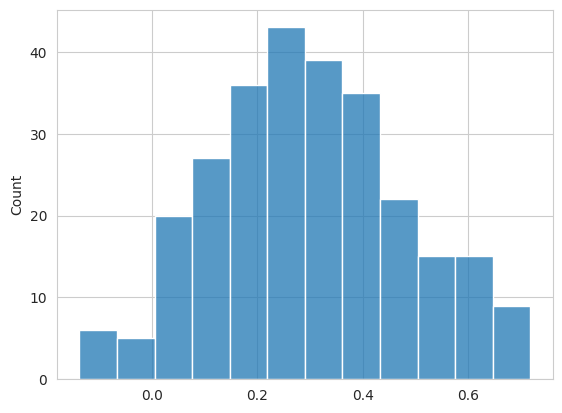

In [354]:
sns.histplot(test_corrs)
np.mean(test_corrs)

#### Combined figure

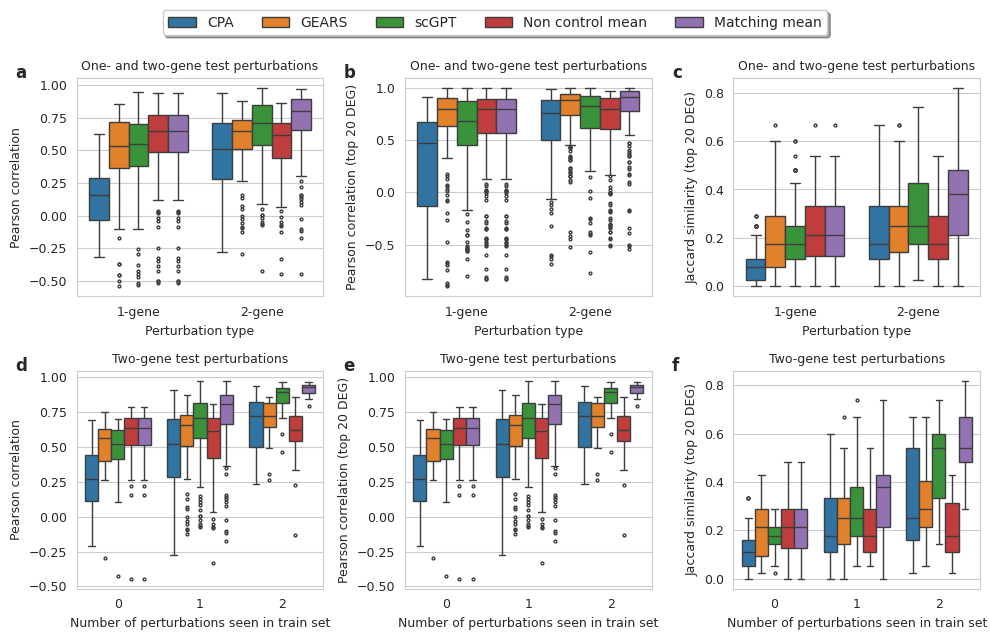

In [114]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
letter_annotation(plt.gca(), -.25, 1, 'a')
sns.boxplot(data=results_df, x='one gene', y='corr_all', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
letter_annotation(plt.gca(), -.25, 1, 'b')
sns.boxplot(data=results_df, x='one gene', y='corr_20de', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 3)
letter_annotation(plt.gca(), -.25, 1, 'c')
sns.boxplot(data=results_df, x='one gene', y='jaccard', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
letter_annotation(plt.gca(), -.25, 1, 'd')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_all', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 5)
letter_annotation(plt.gca(), -.25, 1, 'e')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='corr_all', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 6)
letter_annotation(plt.gca(), -.25, 1, 'f')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='jaccard', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, ncol=5)

labels=['CPA', 'GEARS', 'scGPT', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
# plt.savefig(f'{figdir}/{dataset}_pearsondiff_combined.pdf', bbox_inches='tight');

#### Combined MSE figure

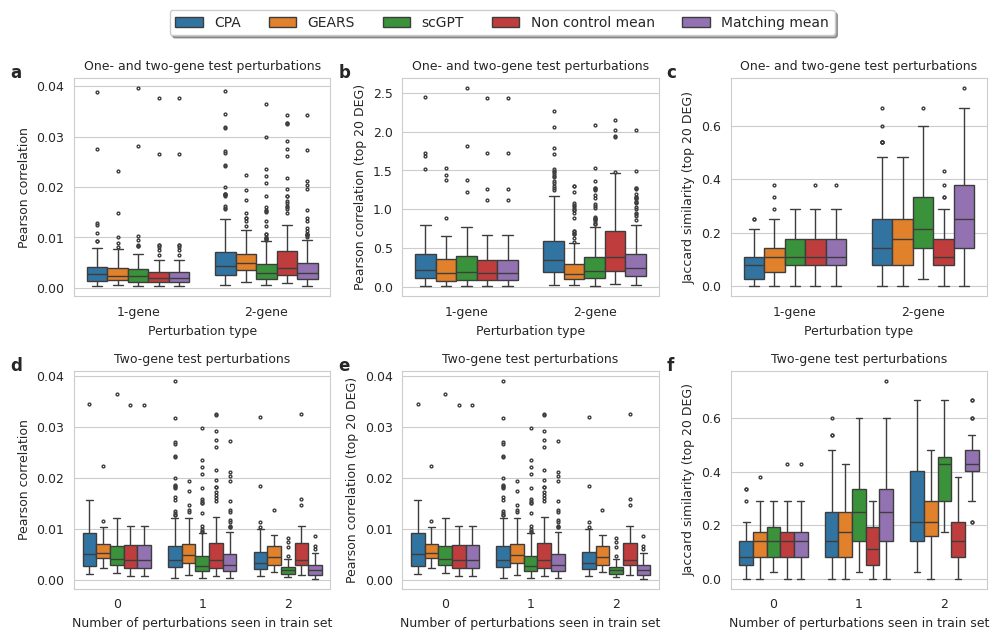

In [8]:
nrows = 2
ncols = 3
fontsize = 9
fliersize = 2
fig = plt.figure(figsize=(10, 6))
plt.subplot(nrows, ncols, 1)
letter_annotation(plt.gca(), -.25, 1, 'a')
sns.boxplot(data=results_df, x='one gene', y='mse_all', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 2)
letter_annotation(plt.gca(), -.25, 1, 'b')
sns.boxplot(data=results_df, x='one gene', y='mse_20de', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

plt.subplot(nrows, ncols, 3)
letter_annotation(plt.gca(), -.25, 1, 'c')
sns.boxplot(data=results_df, x='one gene', y='jaccard', hue='method',
            hue_order=methods,
            fliersize=fliersize,
            order=['1-gene', '2-gene'])
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('One- and two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Perturbation type', fontsize=fontsize)

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 4)
letter_annotation(plt.gca(), -.25, 1, 'd')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='mse_all', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 5)
letter_annotation(plt.gca(), -.25, 1, 'e')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='mse_all', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Pearson correlation (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# Results: 2-gene perturbation by number of perturbations in train
plt.subplot(nrows, ncols, 6)
letter_annotation(plt.gca(), -.25, 1, 'f')
sns.boxplot(data=results_df[results_df['one gene'] == '2-gene'], x='train', y='jaccard', hue='method',
            fliersize=fliersize,
            hue_order=methods)
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.title('Two-gene test perturbations', fontsize=fontsize)
plt.ylabel('Jaccard similarity (top 20 DEG)', fontsize=fontsize)
plt.legend([],[], frameon=False);
plt.xlabel('Number of perturbations seen in train set', fontsize=fontsize);

# legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, ncol=5)

labels=['CPA', 'GEARS', 'scGPT', 'Non control mean', 'Matching mean']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label)

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig(f'{figdir}/{dataset}_msediff_combined.pdf', bbox_inches='tight');